## Objective:
Given the scheduled/actual departure time and delays, whether a flight will get delayed or not. Delay threshold used for this dataset is 0 minutes (That is, if a flight is even 1 minute over its scheduled arrival time it will be classified as delayed).

In [2]:
# import libraries
import numpy as np
import pandas as pd
import glob, os
from datetime import datetime as dt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Reading Dataset

In [3]:
# Read all csv data
path = # Your Path to the Dataset
all_files = glob.glob(os.path.join(path, '*.csv'))

# Get all header names
data_headers = pd.concat((pd.read_csv(file, header = None, nrows = 1) for file in all_files), ignore_index = True)

In [4]:
data_headers.iloc[0,:].values

array(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'FL_DATE', 'UNIQUE_CARRIER', 'AIRLINE_ID', 'CARRIER', 'TAIL_NUM',
       'FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',
       'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_CITY_NAME',
       'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM',
       'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID',
       'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR',
       'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE',
       'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHE

In [5]:
# Select subset of columns
col_names = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'FL_DATE', 'UNIQUE_CARRIER', 'AIRLINE_ID', 'CARRIER', 'TAIL_NUM',
       'FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME',
       'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR',
       'DEST_STATE_NM', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE']

In [6]:
# Read all data based on the subset of columns
data = pd.concat((pd.read_csv(file, usecols = col_names) for file in all_files), ignore_index = True)

# Data Exploration / Analysis

In [8]:
data.shape

(5819079, 36)

In [9]:
data.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'UNIQUE_CARRIER', 'AIRLINE_ID', 'CARRIER', 'TAIL_NUM', 'FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR',
       'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS',
       'DISTANCE'],
      dtype='object')

#### Create column FL_DELAYED to be used as output label for classification

In [10]:
data['FL_DELAYED'] = np.where(data['ARR_DELAY_NEW'] > 0.0, 1, 0)

In [11]:
data['FL_DELAYED'].value_counts()

0    3732183
1    2086896
Name: FL_DELAYED, dtype: int64

#### Check missing values in the dataset

In [12]:
data.isnull().sum()

YEAR                        0
QUARTER                     0
MONTH                       0
DAY_OF_MONTH                0
DAY_OF_WEEK                 0
FL_DATE                     0
UNIQUE_CARRIER              0
AIRLINE_ID                  0
CARRIER                     0
TAIL_NUM                14721
FL_NUM                      0
ORIGIN_AIRPORT_ID           0
ORIGIN                      0
ORIGIN_CITY_NAME            0
ORIGIN_STATE_ABR            0
ORIGIN_STATE_NM             0
DEST_AIRPORT_ID             0
DEST                        0
DEST_CITY_NAME              0
DEST_STATE_ABR              0
DEST_STATE_NM               0
CRS_DEP_TIME                0
DEP_TIME                86153
DEP_DELAY_NEW           86153
DEP_DEL15               86153
DEP_DELAY_GROUP         86153
CRS_ARR_TIME                0
ARR_TIME                92513
ARR_DELAY_NEW          105071
ARR_DEL15              105071
ARR_DELAY_GROUP        105071
CRS_ELAPSED_TIME            6
ACTUAL_ELAPSED_TIME    105071
AIR_TIME  

#### Some time values show 2400 (24:00) hours for midnight. Converting them to standard 0000 (00:00) hours.

In [13]:
data['DEP_TIME'].replace(to_replace=2400.0, value=0.0, inplace=True)

In [14]:
data['CRS_ARR_TIME'].replace(to_replace=2400.0, value=0.0, inplace=True)

In [15]:
data['ARR_TIME'].replace(to_replace=2400.0, value=0.0, inplace=True)

#### Convert integer/float time values into hh:mm:ss timestamp format.

In [16]:
data['CRS_DEP_TIMESTAMP'] = (pd.to_timedelta(data['CRS_DEP_TIME']//100, unit='h')
                             + pd.to_timedelta(data['CRS_DEP_TIME']%100, unit='m'))

In [17]:
data['DEP_TIMESTAMP'] = (pd.to_timedelta(data['DEP_TIME']//100, unit='h') 
                         + pd.to_timedelta(data['DEP_TIME']%100, unit='m'))

In [18]:
data['CRS_ARR_TIMESTAMP'] = (pd.to_timedelta(data['CRS_ARR_TIME']//100, unit='h') 
                             + pd.to_timedelta(data['CRS_ARR_TIME']%100, unit='m'))

In [19]:
data['ARR_TIMESTAMP'] = (pd.to_timedelta(data['ARR_TIME']//100, unit='h') 
                         + pd.to_timedelta(data['ARR_TIME']%100, unit='m'))

#### Convert FL_DATE from String to Date format

In [20]:
data['FL_DT'] = pd.to_datetime(data['FL_DATE'])

### Imputing Missing Data

In [24]:
# % of rows with Null values for ARR_DELAY_NEW
(len(data[data['ARR_DELAY_NEW'].isnull()]) / len(data['ARR_DELAY_NEW'])) * 100

1.8056293788071962

In [25]:
# Removing rows with Null values for ARR_DELAY_NEW (since less than 2% data is missing)
cleaned_data = pd.DataFrame(data[data['ARR_DELAY_NEW'].notnull()])

In [26]:
# Sanity check for null values
cleaned_data.isnull().sum()

YEAR                   0
QUARTER                0
MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
FL_DATE                0
UNIQUE_CARRIER         0
AIRLINE_ID             0
CARRIER                0
TAIL_NUM               0
FL_NUM                 0
ORIGIN_AIRPORT_ID      0
ORIGIN                 0
ORIGIN_CITY_NAME       0
ORIGIN_STATE_ABR       0
ORIGIN_STATE_NM        0
DEST_AIRPORT_ID        0
DEST                   0
DEST_CITY_NAME         0
DEST_STATE_ABR         0
DEST_STATE_NM          0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY_NEW          0
DEP_DEL15              0
DEP_DELAY_GROUP        0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY_NEW          0
ARR_DEL15              0
ARR_DELAY_GROUP        0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
FLIGHTS                0
DISTANCE               0
FL_DELAYED             0
CRS_DEP_TIMESTAMP      0
DEP_TIMESTAMP          0
CRS_ARR_TIMESTAMP      0


#### Class distribution for FL_DELAYED (target feature)

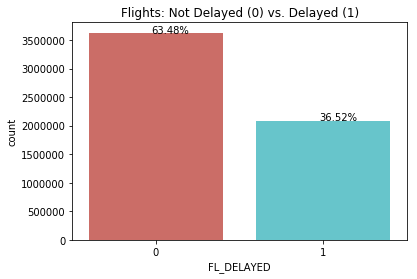

In [71]:
f, ax = plt.subplots(1, 1)
ax = sns.countplot(x='FL_DELAYED', data=cleaned_data, palette='hls')

for p, label in zip(ax.patches, cleaned_data.groupby('FL_DELAYED').size().transform(lambda x: x/sum(x) * 100)):
    ax.annotate(str(round(label,2))+'%', (p.get_x()+0.375, p.get_height()+0.15))

ax.set_title('Flights: Not Delayed (0) vs. Delayed (1)')
plt.show()

##### Inference: 
- Flight Delay Distribution:
    - Not Delayed = 63.48%
    - Delayed = 36.52%

In [64]:
cleaned_data.loc[:,['CRS_DEP_TIMESTAMP', 'DEP_TIMESTAMP', 'DEP_DELAY_NEW', 'CRS_ARR_TIMESTAMP',
                   'ARR_TIMESTAMP', 'ARR_DELAY_NEW', 'AIR_TIME', 'DISTANCE']].groupby(cleaned_data['FL_DELAYED']).mean()

,DEP_DELAY_NEW,ARR_DELAY_NEW,AIR_TIME,DISTANCE
FL_DELAYED,,,,
0,0.980439,0.00000,112.128135,825.348605
1,31.267001,33.11299,115.916197,822.907088


##### Inference: 
- Average Arrival delay is 33 minutes. 
- Average Air Time for delayed flights is higher than non-delayed flights. 
- Average Distance travelled by delayed flights is less than non-delayed flights.

In [417]:
cleaned_data[cleaned_data['ARR_DELAY_NEW'] > 0].loc[:,'ARR_DELAY_NEW'].describe().apply(lambda x: format(x,'f'))

count    2086896.000000
mean          33.112990
std           52.942508
min            1.000000
25%            6.000000
50%           15.000000
75%           38.000000
max         1971.000000
Name: ARR_DELAY_NEW, dtype: object

In [401]:
len(cleaned_data[cleaned_data['ARR_DELAY_NEW'] > 139])

85443

##### Inference:  
- As per the descriptive statistics, much of the delay time (~98.5%) is observed within 139 minutes (2 std. deviations).

In [422]:
cleaned_data.loc[:,['CRS_DEP_TIMESTAMP', 'DEP_TIMESTAMP', 'DEP_DELAY_NEW', 'CRS_ARR_TIMESTAMP',
                   'ARR_TIMESTAMP', 'ARR_DELAY_NEW', 'AIR_TIME', 'DISTANCE']].groupby([cleaned_data['UNIQUE_CARRIER'], 
                                                                                       cleaned_data['FL_DELAYED']]).mean()

DEP_DELAY_NEW  ARR_DELAY_NEW    AIR_TIME  \
UNIQUE_CARRIER FL_DELAYED                                             
AA             0                0.944312       0.000000  137.749305   
               1               31.461369      34.148364  143.564096   
AS             0                0.602327       0.000000  159.613289   
               1               18.470528      22.562411  154.289765   
B6             0                1.094005       0.000000  137.888506   
               1               35.635091      38.132807  153.225936   
DL             0                1.022506       0.000000  113.360538   
               1               30.642948      32.077424  121.356961   
EV             0                0.469928       0.000000   70.645594   
               1               31.396071      35.198042   76.156892   
F9             0                0.712575       0.000000  127.636968   
               1               36.666521      41.190435  133.325718   
HA             0                0.227465       0.000000   76.062252   
               1               10.847576      15.379767   98.283343   
MQ             0                0.620112       0.000000   64.657440   
               1               34.722728      39.509202   70.912265   
NK             0                0.921312       0.000000  129.416955   
               1               37.237277      40.659852  135.351926   
OO             0                0.465846       0.000000   73.592236   
               1               29.221687      32.437278   78.941381   
UA             0                2.038941       0.000000  163.399599   
               1               40.965145      39.209314  167.315744   
US             0                0.724728       0.000000  122.400304   
               1               22.033126      27.419925  130.990391   
VX             0                1.106939       0.000000  187.027922   
               1               27.452192      30.725227  175.889992   
WN             0                1.203044       0.000000  103.616966   
               1               30.215718      29.418496  102.253920   

                              DISTANCE  
UNIQUE_CARRIER FL_DELAYED               
AA             0           1041.007670  
               1           1044.866232  
AS             0           1231.691464  
               1           1132.337050  
B6             0           1030.343349  
               1           1114.370350  
DL             0            845.022508  
               1            874.771153  
EV             0            454.486940  
               1            473.258830  
F9             0            963.511728  
               1            971.474340  
HA             0            572.505647  
               1            722.479638  
MQ             0            412.625053  
               1            439.658026  
NK             0            979.394831  
               1            992.316997  
OO             0            489.536722  
               1            510.776371  
UA             0           1273.342638  
               1           1268.820096  
US             0            907.024369  
               1            928.298617  
VX             0           1458.109879  
               1           1322.005707  
WN             0            755.189316  
               1            719.733845

#### Arline distribution plot

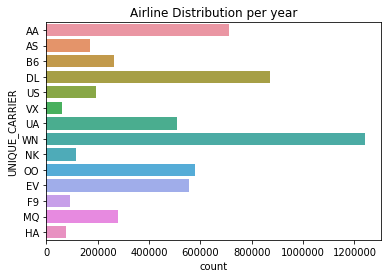

In [67]:
sns.countplot(y='UNIQUE_CARRIER', data=cleaned_data)
plt.title('Airline Distribution per year')
plt.show()

##### Inference: 
- WN, DL, AA, OO, EV, UA have the most number of flights during the year.

#### Monthly distribution of flights

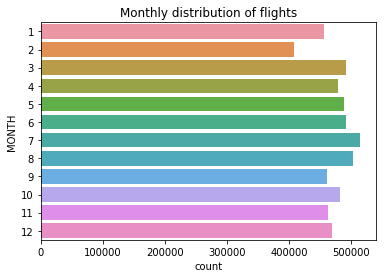

In [68]:
sns.countplot(y='MONTH', data=cleaned_data)
plt.title('Monthly distribution of flights')
plt.show()

##### Inference: 
- March, June and July seem to be the busiest months.

#### Actual Arrival Time Distribution

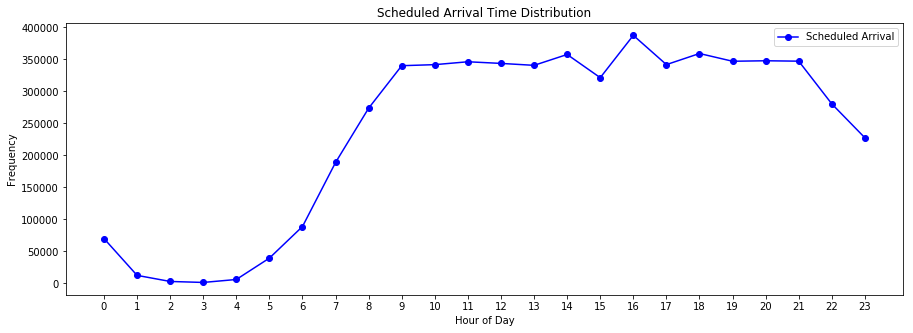

In [73]:
fig, ax = plt.subplots(figsize=(15,5))
cleaned_data['FL_NUM'].groupby(cleaned_data['CRS_ARR_TIMESTAMP'].astype('timedelta64[h]')).count().plot(kind="line", color='blue', marker='o', label='Scheduled Arrival')
#cleaned_data['FL_NUM'].groupby(cleaned_data['ARR_TIMESTAMP'].astype('timedelta64[h]')).count().plot(kind="line", color='red', label='Actual Arrival')
ax.xaxis.set_ticks(np.arange(0, 24, 1))
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Frequency')
plt.title('Scheduled Arrival Time Distribution')
plt.legend()

##### Inference: 
- 9 AM to 9 PM seems to be the busiest time frame in a day.

# Model Building and Testing

#### Subsetting Input columns for model building

In [80]:
input_cols = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DT',
                'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST',
                'DEST_STATE_ABR', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'CRS_ARR_TIME',
                'ARR_TIME', 'ARR_DELAY_NEW', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 
                'FLIGHTS', 'DISTANCE', 'CRS_DEP_TIMESTAMP', 'DEP_TIMESTAMP', 'CRS_ARR_TIMESTAMP',
                'ARR_TIMESTAMP', 'FL_DELAYED']

In [81]:
input_data = pd.DataFrame(cleaned_data[input_cols])

### Generic function to build a classification model and assess performance

In [83]:
def classification_model(model, data, predictors, target):
    
    # Split the data into Train(60%), CV(20%) and Test(20%) datasets.
    # sample() function randomly samples from the dataframe.
    # split() function splits the randomly sampled data into 2 splits: one at 60% length and other at 80% length.
    train_data, cv_data, test_data = np.split(data.sample(frac=1, random_state=1001), [int(.6*len(data)), int(.8*len(data))])
    
    ###############################
    #       TRAIN the model       #
    ###############################
    
    # Fit/train the model on training dataset
    model.fit(train_data[predictors], train_data[target])
    
    # Make predictions on the training dataset
    train_prediction = model.predict(train_data[predictors])
    
    # Measure the training accuracy
    train_accuracy = metrics.accuracy_score(train_data[target], train_prediction)
    print('Training Accuracy: %s' % "{0:.3%}".format(train_accuracy))
    
    ###############################
    #      CROSS-VALIDATION       #
    ###############################
    
    # Run K-fold Cross-validation on CV dataset
    kf = KFold(n_splits=3, shuffle=True, random_state=1001)
    
    error = []
    
    for trainCV_index, testCV_index in kf.split(cv_data):
        # Filter training CV data for predictors
        trainCV_predictors = cv_data[predictors].iloc[trainCV_index, :]
        
        # Filter test CV data for target feature
        trainCV_target = cv_data[target].iloc[trainCV_index]
        
        # Fit/train the model on the CV dataset
        model.fit(trainCV_predictors, trainCV_target)
        
        # Record error from each CV run on CV dataset
        error.append(model.score(cv_data[predictors].iloc[testCV_index, :], cv_data[target].iloc[testCV_index]))
        
    print('Cross-validation score: %s' % "{0:.3%}".format(np.mean(error)))
    
    ###############################
    #       TEST the model        #
    ###############################
    
    # Fit/train the model on Test dataset
    model.fit(test_data[predictors], test_data[target])
    
    # Make predictions on the Test dataset
    test_prediction = model.predict(test_data[predictors])
    
    # Measure the Test accuracy
    test_accuracy = metrics.accuracy_score(test_data[target], test_prediction)
    print('Test Accuracy: %s' % "{0:.3%}".format(test_accuracy))
    
    # Compute the Test confusion matrix. Provding labels so that the matrix treats '1' as a True label.
    test_conf_matrix = metrics.confusion_matrix(test_data[target], test_prediction, labels=[1,0])
    print('Test Confusion Matrix:\n', test_conf_matrix)
    
    # Compute the Test classification report
    test_classification_report = metrics.classification_report(test_data[target], test_prediction, 
                                                               labels=[1,0], target_names=['Delayed', 'Not Delayed'])
    print('Test Classification Report:\n', test_classification_report)
    
    # Plot the ROC curve
    logit_roc_auc = metrics.roc_auc_score(test_data[target], test_prediction)
    fpr, tpr, thresholds = metrics.roc_curve(test_data[target], model.predict_proba(test_data[predictors])[:,1], pos_label=1)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    
    # Return the learned model
    return model

#### Converting FL_DT into numeric format equivalent to the number of days from the minimum date in the dataset to feed into the model.

In [84]:
input_data['FL_DT_DAYS'] = (input_data['FL_DT'] - input_data['FL_DT'].min()) / np.timedelta64(1, 'D')

### Model 1: Logistic Regression

#### Pre-processing:

- Removing multi-collinearity: Convert FL_DT into ordinal fomat and removing YEAR, QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK from the model input as they represent the same data as FL_DT.
- Removing FL_NUM as I think it doesn't add relationship to the predict target variable.
- Adding CRS_ELAPSED_TIME and DISTANCE to the input features.

In [85]:
input_data['FL_DT_ORDINAL'] = input_data['FL_DT'].apply(dt.toordinal)

Training Accuracy: 78.742%
Cross-validation score: 79.515%
Test Accuracy: 80.663%
Test Confusion Matrix:
 [[204263 212981]
 [  8004 717554]]
Test Classification Report:
              precision    recall  f1-score   support

    Delayed       0.96      0.49      0.65    417244
Not Delayed       0.77      0.99      0.87    725558

avg / total       0.84      0.81      0.79   1142802



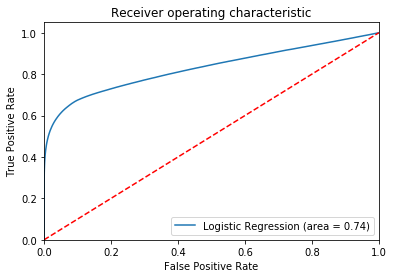

In [86]:
model = LogisticRegression()
target_var = 'FL_DELAYED'
predictors_var = ['FL_DT_ORDINAL', 'FL_NUM', 'FL_DT_DAYS', 'DEP_DELAY_NEW', 'CRS_ELAPSED_TIME','DISTANCE']
logreg = classification_model(model, input_data, predictors_var, target_var)

### Model 2: Decision Tree Classifier

Removing FL_DT_DAYS as it might represent same information as FL_DT_ORDINAL

Training Accuracy: 99.981%
Cross-validation score: 74.844%
Test Accuracy: 99.993%
Test Confusion Matrix:
 [[417161     83]
 [     0 725558]]
Test Classification Report:
              precision    recall  f1-score   support

    Delayed       1.00      1.00      1.00    417244
Not Delayed       1.00      1.00      1.00    725558

avg / total       1.00      1.00      1.00   1142802



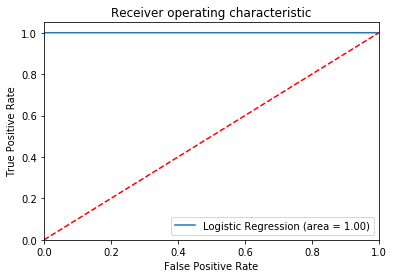

In [519]:
model = DecisionTreeClassifier()
target_var = 'FL_DELAYED'
predictors_var = ['FL_DT_ORDINAL', 'FL_NUM', 'DEP_DELAY_NEW', 'CRS_ELAPSED_TIME', 'DISTANCE']

# Returns the learned model
dtc = classification_model(model, input_data, predictors_var, target_var)

### Model 3: Random Forest Classifier

Training Accuracy: 98.063%
Cross-validation score: 80.835%
Test Accuracy: 98.061%
Test Confusion Matrix:
 [[396606  20638]
 [  1516 724042]]
Test Classification Report:
              precision    recall  f1-score   support

    Delayed       1.00      0.95      0.97    417244
Not Delayed       0.97      1.00      0.98    725558

avg / total       0.98      0.98      0.98   1142802



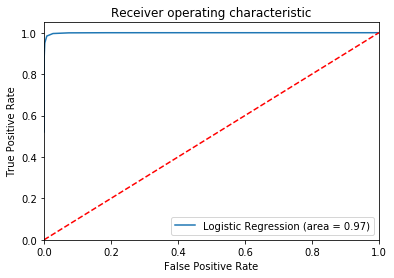

In [98]:
model = RandomForestClassifier()
target_var = 'FL_DELAYED'
predictors_var = ['FL_DT_ORDINAL', 'FL_NUM', 'DEP_DELAY_NEW', 'CRS_ELAPSED_TIME', 'DISTANCE']

# Returns the learned model
rfc = classification_model(model, input_data, predictors_var, target_var)

#### Feature Importance

In [193]:
df_feature_imp = pd.DataFrame(rfc.feature_importances_, index = predictors_var, columns = ['Feature_Importance'])

In [194]:
df_feature_imp.sort_values(by = 'Feature_Importance', ascending = False, inplace = True)

In [195]:
df_feature_imp

,Feature_Importance
DEP_DELAY_NEW,0.433637
FL_DT_ORDINAL,0.197912
FL_NUM,0.148707
DISTANCE,0.113851
CRS_ELAPSED_TIME,0.105893


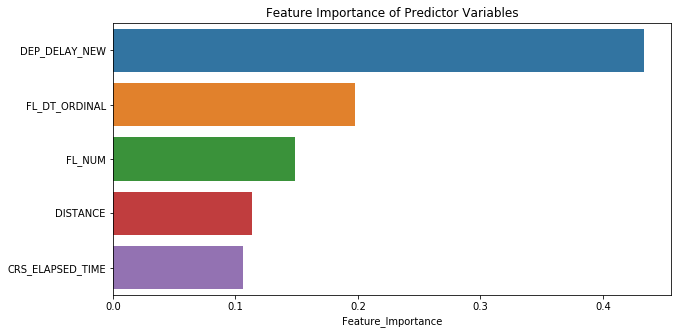

In [197]:
f, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(y = df_feature_imp.index, x = df_feature_imp['Feature_Importance'])
plt.title('Feature Importance of Predictor Variables')
plt.savefig('Feature_Imp_Plot')
plt.show()

##### Inference:
- "Delay in Depature time" of the flight is the most important feature to predict whether a flight will arrive late (i.e., Delayed) or arrive on time (i.e., not delayed) at the Destination Airport.